### Observations

**HighLevelGraphs**

How to get the HighLevelGraph:

- `res.data.dask` or `res.__dask_graph__()` to get the graph in layers format.

- `res.data.dask.visualize()` or `res.__dask_graph__().visualize()` to get in graph format.

  
Internals:

- HLG is a dict, `res.data.dask.__dict__`. It has the nodes and keys of the task graphs. (which is basically the low level graph's nodes)

- `res.data.dask.dependencies` to get the layers, dependencies and key_dependencies.

- `res.__dask_graph__().keys`  or `res.data.dask.keys` would give the layers as keys. (res.data.dask.values also gives the same, i.e keys and values are same)

- On `res.data.dask.` we can perform these operations [cull, merge, cull_layers, validate, get, copy, dependents, get_all_dependencies, visualize].

Notes:

- `type(dask.visualize(res))` this gets the low level graph, but the type is an Image. `type(res.data.dask)` this gets the HLG, and the type is also HLG.
  

### Fuse and HighLevelGraph

In [62]:
# from dask.distributed import Client
# client = Client(address = "tcp://192.168.0.100:8786")

In [63]:
# client

In [1]:
import xarray as xr
import dask.array as da
import numpy as np

# (a+b)^2 = a^2 + b^2 + 2ab

a = da.from_array([1, 2, 3, 4], chunks = (1))
b = da.from_array([5, 6, 7, 8], chunks = (1))
xr_a = xr.DataArray(a)
xr_b = xr.DataArray(b)

def add(arr1, arr2):
    return arr1 + arr2

def sq(arr):
    return arr ** 2

def mul(arr1, arr2):
    return arr1 * arr2

a_sq = sq(xr_a) 
b_sq = sq(xr_b)
add_ab = add(a_sq, b_sq) # a^2 +b^2
mul_ab = mul(xr_a, xr_b) # ab

res = add(add_ab, mul_ab)

# res.__dask_layers__() -> dk
# dask.visualize(res) -> low level graphs
# dask.optimize(a)
# a.npartitions # gives no.of chunks
# a.chunksize # gives chunk size
# res.__dask_keys__() -> dont know the real reason behind the keys


# compute 
# dask delayed
# from_collections()


In [2]:
res.compute()

<xarray.DataArray (dim_0: 4)> Size: 32B
array([ 31,  52,  79, 112])
Dimensions without coordinates: dim_0

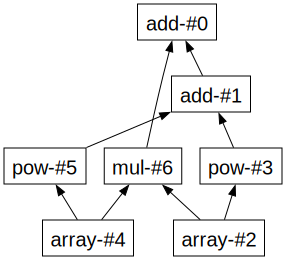

In [3]:
res.data.dask.visualize()

In [4]:
import dask

graph = res.data.dask

hlg_keys = res.data.dask.keys

In [38]:
from dask.threaded import get
from dask.optimization import fuse, fuse_linear

outputs = "add-ffe880f167c9131320013be9069dfca1"
graph2, dep = fuse(dict(graph), fuse_subgraphs=True)

In [39]:
keys = graph2.keys()
print(keys)
get(graph2, ('add-ffe880f167c9131320013be9069dfca1', 0))

dict_keys([('add-ffe880f167c9131320013be9069dfca1', 0), ('add-ffe880f167c9131320013be9069dfca1', 1), ('add-ffe880f167c9131320013be9069dfca1', 2), ('add-ffe880f167c9131320013be9069dfca1', 3), ('add-d8368b0c413b7b1ff3e4545d5d219543', 0), ('add-d8368b0c413b7b1ff3e4545d5d219543', 1), ('add-d8368b0c413b7b1ff3e4545d5d219543', 2), ('add-d8368b0c413b7b1ff3e4545d5d219543', 3), ('array-93fac394d6028ca1841a0aaaf012fdfd', 0), ('array-93fac394d6028ca1841a0aaaf012fdfd', 1), ('array-93fac394d6028ca1841a0aaaf012fdfd', 2), ('array-93fac394d6028ca1841a0aaaf012fdfd', 3), ('pow-f98325ba6ded8b13c46607d966ba51d1', 0), ('pow-f98325ba6ded8b13c46607d966ba51d1', 1), ('pow-f98325ba6ded8b13c46607d966ba51d1', 2), ('pow-f98325ba6ded8b13c46607d966ba51d1', 3), ('array-e0289449abd23dc644f0fd074cd695dc', 0), ('array-e0289449abd23dc644f0fd074cd695dc', 1), ('array-e0289449abd23dc644f0fd074cd695dc', 2), ('array-e0289449abd23dc644f0fd074cd695dc', 3), ('pow-5022bc0a56d6e28f1fd172a750ba8cff', 0), ('pow-5022bc0a56d6e28f1fd172

array([31])

### Call delayed on HLG

In [7]:

from dask.delayed import Delayed, delayed
root_key = "add-ffe880f167c9131320013be9069dfca1"

g1 = graph
result = delayed(graph)
result.compute()

HighLevelGraph with 7 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x16447d720>
 0. array-e0289449abd23dc644f0fd074cd695dc
 1. pow-5022bc0a56d6e28f1fd172a750ba8cff
 2. array-93fac394d6028ca1841a0aaaf012fdfd
 3. mul-8e9e32e19f9c6e612b3800864d8cc810
 4. pow-f98325ba6ded8b13c46607d966ba51d1
 5. add-d8368b0c413b7b1ff3e4545d5d219543
 6. add-ffe880f167c9131320013be9069dfca1

In [8]:
# https://github.com/ska-sa/katsdpcal/blob/e13c3442ae7be050a7455bc384116aae8e082895/katsdpcal/inplace.py#L250


# Returns equivalent dask collections that all share the same merged and
# optimized underlying graph. This can be useful if converting multiple
# collections to delayed objects, or to manually apply the optimizations at
# strategic points.  
# https://github.com/dask/dask/blob/aafde77e5c7f5220775635a0035c7ae64310ed3a/dask/base.py#L588

# def repack(results):
#         dsk = repack_dsk.copy()
#         dsk[collections_token] = quote(results)
#         return simple_get(dsk, out)

# Quote: Ensure that this value remains this value in a dask graph https://github.com/dask/dask/blob/main/dask/core.py#L515


### dask delayed and fuse


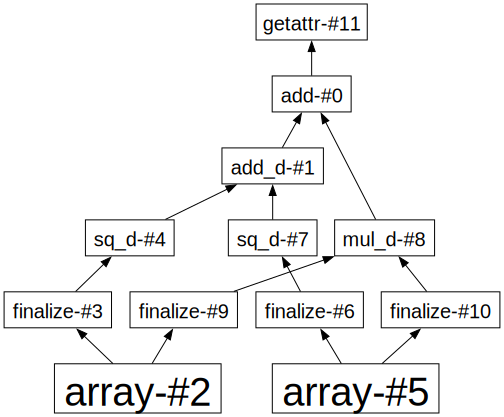

In [9]:
import xarray as xr
import dask.array as da
import numpy as np

# (a+b)^2 = a^2 + b^2 + 2ab

a = da.from_array([1, 2, 3, 4], chunks = (1))
b = da.from_array([5, 6, 7, 8], chunks = (1))
xr_a = xr.DataArray(a)
xr_b = xr.DataArray(b)

@dask.delayed
def add_d(arr1, arr2):
    return arr1 + arr2

@dask.delayed
def sq_d(arr):
    return arr ** 2

@dask.delayed
def mul_d(arr1, arr2):
    return arr1 * arr2

a_sq = sq_d(xr_a) 
b_sq = sq_d(xr_b)
add_ab = add_d(a_sq, b_sq) # a^2 +b^2
mul_ab = mul_d(xr_a, xr_b) # ab

res_d = add(add_ab, mul_ab)
delayed_hgl = res_d.data.dask
delayed_hgl.visualize()

In [10]:
dict(delayed_hgl)

{'add-a362066893b349d99b2b19a5d658fccb': (<function _operator.add(a, b, /)>,
  'add_d-a0be0541-c05e-46af-b8c5-df5fb17eea90',
  'mul_d-f2fc9779-b3f6-4bec-8822-f5f6fe8041e0'),
 'add_d-a0be0541-c05e-46af-b8c5-df5fb17eea90': (<function __main__.add_d(arr1, arr2)>,
  'sq_d-96134174-5594-4c11-bb93-b045188f8a65',
  'sq_d-57df3f05-4ad2-41b4-bf02-4f82ddcaa741'),
 ('array-93fac394d6028ca1841a0aaaf012fdfd', 0): array([1]),
 ('array-93fac394d6028ca1841a0aaaf012fdfd', 1): array([2]),
 ('array-93fac394d6028ca1841a0aaaf012fdfd', 2): array([3]),
 ('array-93fac394d6028ca1841a0aaaf012fdfd', 3): array([4]),
 'finalize-71ed3afe-61b1-46e5-8a49-2c36a9e8826f': (<bound method DataArray._dask_finalize of <class 'xarray.core.dataarray.DataArray'>>,
  [[('array-93fac394d6028ca1841a0aaaf012fdfd', 0),
    ('array-93fac394d6028ca1841a0aaaf012fdfd', 1),
    ('array-93fac394d6028ca1841a0aaaf012fdfd', 2),
    ('array-93fac394d6028ca1841a0aaaf012fdfd', 3)]],
  'array-93fac394d6028ca1841a0aaaf012fdfd',
  <bound method D

In [52]:
client.get(dict(delayed_hgl), 'add-a362066893b349d99b2b19a5d658fccb')
# get(dict(delayed_hgl), 'add-a362066893b349d99b2b19a5d658fccb')

<xarray.DataArray (dim_0: 4)> Size: 32B
array([ 31,  52,  79, 112])
Dimensions without coordinates: dim_0

In [12]:
delayed_hgl

HighLevelGraph with 12 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x16447d4e0>
 0. array-e0289449abd23dc644f0fd074cd695dc
 1. finalize-abb81368-05d0-48fd-bc81-4da3d383a026
 2. finalize-89a5a21d-b67f-47b9-969d-bf82c9f632d6
 3. sq_d-57df3f05-4ad2-41b4-bf02-4f82ddcaa741
 4. array-93fac394d6028ca1841a0aaaf012fdfd
 5. finalize-8e4a37e5-68d7-4d57-908c-05611cb218a2
 6. mul_d-f2fc9779-b3f6-4bec-8822-f5f6fe8041e0
 7. finalize-71ed3afe-61b1-46e5-8a49-2c36a9e8826f
 8. sq_d-96134174-5594-4c11-bb93-b045188f8a65
 9. add_d-a0be0541-c05e-46af-b8c5-df5fb17eea90
 10. add-a362066893b349d99b2b19a5d658fccb
 11. getattr-d83101a6b9634af52ae2ed30c7d8dba0

In [13]:
delayed_hgl.layers

{'add-a362066893b349d99b2b19a5d658fccb': <dask.highlevelgraph.MaterializedLayer at 0x16447ceb0>,
 'add_d-a0be0541-c05e-46af-b8c5-df5fb17eea90': <dask.highlevelgraph.MaterializedLayer at 0x16447cc10>,
 'array-93fac394d6028ca1841a0aaaf012fdfd': <dask.highlevelgraph.MaterializedLayer at 0x164d21930>,
 'finalize-71ed3afe-61b1-46e5-8a49-2c36a9e8826f': <dask.highlevelgraph.MaterializedLayer at 0x164d8c8e0>,
 'sq_d-96134174-5594-4c11-bb93-b045188f8a65': <dask.highlevelgraph.MaterializedLayer at 0x164d22920>,
 'array-e0289449abd23dc644f0fd074cd695dc': <dask.highlevelgraph.MaterializedLayer at 0x164d8c1f0>,
 'finalize-89a5a21d-b67f-47b9-969d-bf82c9f632d6': <dask.highlevelgraph.MaterializedLayer at 0x164d8ca00>,
 'sq_d-57df3f05-4ad2-41b4-bf02-4f82ddcaa741': <dask.highlevelgraph.MaterializedLayer at 0x108e85c30>,
 'mul_d-f2fc9779-b3f6-4bec-8822-f5f6fe8041e0': <dask.highlevelgraph.MaterializedLayer at 0x16447d2a0>,
 'finalize-8e4a37e5-68d7-4d57-908c-05611cb218a2': <dask.highlevelgraph.Materialized

In [56]:
from dask.optimization import fuse, fuse_linear
from dask.highlevelgraph import HighLevelGraph

# print(delayed_hgl.layers)
sel_layers = delayed_hgl.layers
merged_hgl = delayed_hgl.merge(sel_layers)

# print(dict(merged_hgl))

get(dict(merged_hgl),'add-a362066893b349d99b2b19a5d658fccb' )

# delayed_hgl.__dir__()

# help(HighLevelGraph.validate)
from dask.distributed import Client

client = Client("tcp://192.168.0.100:8786")

# help(dask.distributed.get)
# get(dict(merged_hgl) , 'add-a362066893b349d99b2b19a5d658fccb' )
# print(delayed_hgl.validate())
dict(merged_hgl)

{'add-a362066893b349d99b2b19a5d658fccb': <dask.highlevelgraph.MaterializedLayer at 0x16447ceb0>,
 'add_d-a0be0541-c05e-46af-b8c5-df5fb17eea90': <dask.highlevelgraph.MaterializedLayer at 0x16447cc10>,
 'array-93fac394d6028ca1841a0aaaf012fdfd': <dask.highlevelgraph.MaterializedLayer at 0x164d21930>,
 'finalize-71ed3afe-61b1-46e5-8a49-2c36a9e8826f': <dask.highlevelgraph.MaterializedLayer at 0x164d8c8e0>,
 'sq_d-96134174-5594-4c11-bb93-b045188f8a65': <dask.highlevelgraph.MaterializedLayer at 0x164d22920>,
 'array-e0289449abd23dc644f0fd074cd695dc': <dask.highlevelgraph.MaterializedLayer at 0x164d8c1f0>,
 'finalize-89a5a21d-b67f-47b9-969d-bf82c9f632d6': <dask.highlevelgraph.MaterializedLayer at 0x164d8ca00>,
 'sq_d-57df3f05-4ad2-41b4-bf02-4f82ddcaa741': <dask.highlevelgraph.MaterializedLayer at 0x108e85c30>,
 'mul_d-f2fc9779-b3f6-4bec-8822-f5f6fe8041e0': <dask.highlevelgraph.MaterializedLayer at 0x16447d2a0>,
 'finalize-8e4a37e5-68d7-4d57-908c-05611cb218a2': <dask.highlevelgraph.Materialized

In [64]:
ml = client.get(merged_hgl,'add-a362066893b349d99b2b19a5d658fccb')
ml.__dir__()

['annotations',
 'collection_annotations',
 'mapping',
 '__module__',
 '__doc__',
 '__init__',
 '__contains__',
 '__getitem__',
 '__iter__',
 '__len__',
 'is_materialized',
 'get_output_keys',
 '__abstractmethods__',
 '_abc_impl',
 '__slotnames__',
 '__annotations__',
 'cull',
 'get_dependencies',
 'clone',
 '__copy__',
 '_repr_html_',
 'layer_info_dict',
 '__orig_bases__',
 '__dict__',
 '__weakref__',
 '__slots__',
 'get',
 'keys',
 'items',
 'values',
 '__eq__',
 '__reversed__',
 '__hash__',
 '__subclasshook__',
 '__new__',
 '__repr__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__',
 '__class_getitem__']

In [61]:
dict(ml)

{'add-a362066893b349d99b2b19a5d658fccb': (<function _operator.add(a, b, /)>,
  'add_d-a0be0541-c05e-46af-b8c5-df5fb17eea90',
  'mul_d-f2fc9779-b3f6-4bec-8822-f5f6fe8041e0')}

In [54]:
merged_hgl

HighLevelGraph with 1 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x17be3dba0>
 0. 5977389568

### Dask Custom Graph

In [15]:
custom_graph = { "print" : (print("hello")) }

from dask.threaded import get
get(custom_graph, 'print')

hello


In [16]:
graph = res.data.dask
dask_layers = graph.layers
extr = graph._all_external_keys
extr
layers = graph.layers
layers['add-ffe880f167c9131320013be9069dfca1'].__dir__()

['annotations',
 'collection_annotations',
 'output',
 'output_indices',
 'output_blocks',
 'dsk',
 'numblocks',
 'io_deps',
 'indices',
 'concatenate',
 'new_axes',
 '_dims',
 '_cached_dict',
 '__module__',
 '__annotations__',
 '__doc__',
 '__init__',
 'dims',
 '__repr__',
 '_dict',
 'get_output_keys',
 '__getitem__',
 '__iter__',
 '__len__',
 'is_materialized',
 '_cull_dependencies',
 '_cull',
 'cull',
 'clone',
 '__abstractmethods__',
 '_abc_impl',
 'get_dependencies',
 '__copy__',
 '_repr_html_',
 'layer_info_dict',
 '__orig_bases__',
 '__dict__',
 '__weakref__',
 '__slots__',
 'get',
 '__contains__',
 'keys',
 'items',
 'values',
 '__eq__',
 '__reversed__',
 '__hash__',
 '__subclasshook__',
 '__new__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__',
 '__class_getitem__']

In [17]:
dict(graph).keys()

dict_keys([('add-ffe880f167c9131320013be9069dfca1', 0), ('add-ffe880f167c9131320013be9069dfca1', 1), ('add-ffe880f167c9131320013be9069dfca1', 2), ('add-ffe880f167c9131320013be9069dfca1', 3), ('add-d8368b0c413b7b1ff3e4545d5d219543', 0), ('add-d8368b0c413b7b1ff3e4545d5d219543', 1), ('add-d8368b0c413b7b1ff3e4545d5d219543', 2), ('add-d8368b0c413b7b1ff3e4545d5d219543', 3), ('array-93fac394d6028ca1841a0aaaf012fdfd', 0), ('array-93fac394d6028ca1841a0aaaf012fdfd', 1), ('array-93fac394d6028ca1841a0aaaf012fdfd', 2), ('array-93fac394d6028ca1841a0aaaf012fdfd', 3), ('pow-f98325ba6ded8b13c46607d966ba51d1', 0), ('pow-f98325ba6ded8b13c46607d966ba51d1', 1), ('pow-f98325ba6ded8b13c46607d966ba51d1', 2), ('pow-f98325ba6ded8b13c46607d966ba51d1', 3), ('array-e0289449abd23dc644f0fd074cd695dc', 0), ('array-e0289449abd23dc644f0fd074cd695dc', 1), ('array-e0289449abd23dc644f0fd074cd695dc', 2), ('array-e0289449abd23dc644f0fd074cd695dc', 3), ('pow-5022bc0a56d6e28f1fd172a750ba8cff', 0), ('pow-5022bc0a56d6e28f1fd172

In [18]:
for i in dict(graph):
    print(get(dict(graph), i))
# 31,  52,  79, 112

[31]
[52]
[79]
[112]
[26]
[40]
[58]
[80]
[1]
[2]
[3]
[4]
[1]
[4]
[9]
[16]
[5]
[6]
[7]
[8]
[25]
[36]
[49]
[64]
[5]
[12]
[21]
[32]


In [19]:
for i in extr:
    print(get(extr, i[0]))

3
0
2
2
1
2
1
3
0
3
2
2
2
2
1
2
0
2
1
3
3
0
2
2
3
2
3
3


### xarray vs Numpy on delayed